In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base=automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=base.classes.measurement
Station=base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2017-08-01', '2017-08-07'))

result=calc_temps('2017-08-01', '2017-08-07')
tmin=result[0][0]
tmax=result[0][2]
avg_temp=result[0][1]
error=tmax-tmin

[(72.0, 79.25, 83.0)]


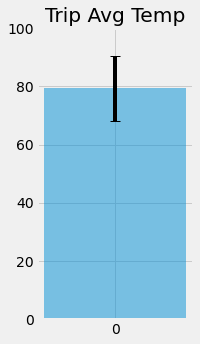

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,5))
xpos= np.arange(1)
ax.bar(xpos,avg_temp,
       width=1,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=5)

ax.set_xticks(xpos)
ax.set_ylim([0,100])
ax.set_title('Trip Avg Temp')

plt.tight_layout()
plt.show()


### Daily Rainfall Average

In [17]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
   
sel=[Measurement.station,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]


result=session.query(*sel).filter(Measurement.date >= '2017-08-01').\
                    filter(Measurement.date <= '2017-08-07').group_by(Measurement.station).\
                     order_by(func.sum(Measurement.prcp).desc()).filter(Measurement.station==Station.station).all()

for row in result:
    print({'Station':row[0],
           'total_prcp':row[1],
           'Latitude':row[2],
          'Longitude':row[3],
          'Elevation':row[4]})

{'Station': 'USC00516128', 'total_prcp': 0.36, 'Latitude': 21.3331, 'Longitude': -157.8025, 'Elevation': 152.4}
{'Station': 'USC00514830', 'total_prcp': 0.22, 'Latitude': 21.5213, 'Longitude': -157.8374, 'Elevation': 7.0}
{'Station': 'USC00519281', 'total_prcp': 0.06, 'Latitude': 21.45167, 'Longitude': -157.84888999999998, 'Elevation': 32.9}
{'Station': 'USC00519397', 'total_prcp': 0.04, 'Latitude': 21.2716, 'Longitude': -157.8168, 'Elevation': 3.0}
{'Station': 'USC00519523', 'total_prcp': 0.0, 'Latitude': 21.33556, 'Longitude': -157.71139, 'Elevation': 19.5}


### Daily Temperature Normals

In [18]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [105]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d

dates=['08-01','08-02','08-03','08-04','08-05','08-06','08-07']

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals=[]
for date in dates:
    result=daily_normals(date)
    normals.append(result[0])
    
print(normals)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [112]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

df=pd.DataFrame(normals,columns=['tmin','tavg','tmax'])
df['date']=dates
df.set_index('date',inplace=True)
df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


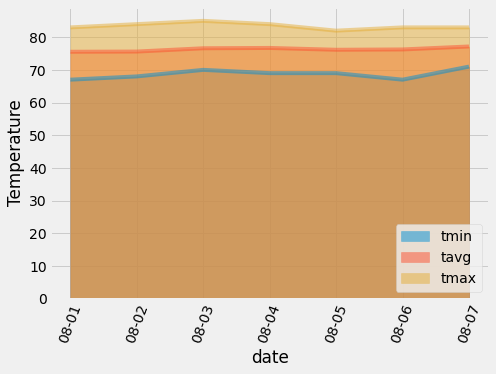

In [123]:
# Plot the daily normals as an area plot with `stacked=False`

df.plot.area(stacked=False,rot=70,figsize=(7,5))
plt.ylabel('Temperature')
plt.legend(loc='lower right')
plt.show()


## Close Session

In [124]:
session.close()